In [1]:
import pandas as pd

df = pd.read_csv('Uber-Jan-Feb-FOIL.csv')

In [2]:
df.head()

,dispatching_base_number,date,active_vehicles,trips
0,B02512,1/1/2015,190,1132
1,B02765,1/1/2015,225,1765
2,B02764,1/1/2015,3427,29421
3,B02682,1/1/2015,945,7679
4,B02617,1/1/2015,1228,9537


In [3]:
display(df.head())
display(df.info())
display(df.isnull().sum())

,dispatching_base_number,date,active_vehicles,trips
0,B02512,1/1/2015,190,1132
1,B02765,1/1/2015,225,1765
2,B02764,1/1/2015,3427,29421
3,B02682,1/1/2015,945,7679
4,B02617,1/1/2015,1228,9537


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   dispatching_base_number  354 non-null    object
 1   date                     354 non-null    object
 2   active_vehicles          354 non-null    int64 
 3   trips                    354 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 11.2+ KB


None

,0
dispatching_base_number,0
date,0
active_vehicles,0
trips,0


In [4]:
df['date'] = pd.to_datetime(df['date'])
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   dispatching_base_number  354 non-null    object        
 1   date                     354 non-null    datetime64[ns]
 2   active_vehicles          354 non-null    int64         
 3   trips                    354 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 11.2+ KB


None

In [5]:
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
display(df.head())

,dispatching_base_number,date,active_vehicles,trips,day_of_week,month
0,B02512,2015-01-01,190,1132,3,1
1,B02765,2015-01-01,225,1765,3,1
2,B02764,2015-01-01,3427,29421,3,1
3,B02682,2015-01-01,945,7679,3,1
4,B02617,2015-01-01,1228,9537,3,1


In [6]:
trips_by_day = df.groupby('day_of_week')['trips'].sum()
display(trips_by_day)

trips_by_month = df.groupby('month')['trips'].sum()
display(trips_by_month)

,trips
day_of_week,
0,463799
1,483061
2,531263
3,665647
4,711192
5,751325
6,523943


,trips
month,
1,1908649
2,2221581


In [7]:
if 'Lat' in df.columns and 'Lon' in df.columns:
    print("Lat and Lon columns exist. Proceeding with geographical analysis.")
else:
    print("Lat and Lon columns do not exist. Cannot perform geographical analysis with the current data.")

Lat and Lon columns do not exist. Cannot perform geographical analysis with the current data.


In [8]:
trips_by_base = df.groupby('dispatching_base_number')['trips'].sum()
display(trips_by_base)

,trips
dispatching_base_number,
B02512,93786
B02598,540791
B02617,725025
B02682,662509
B02764,1914449
B02765,193670


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

features = ['active_vehicles', 'day_of_week', 'month', 'dispatching_base_number']
target = 'trips'

X = df[features]
y = df[target]
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), ['dispatching_base_number'])
    ],
    remainder='passthrough'
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', model)])


pipeline.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['dispatching_base_number'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared (R2): {r2:.2f}')

Mean Absolute Error (MAE): 1046.18
Mean Squared Error (MSE): 2230133.00
Root Mean Squared Error (RMSE): 1493.36
R-squared (R2): 0.98


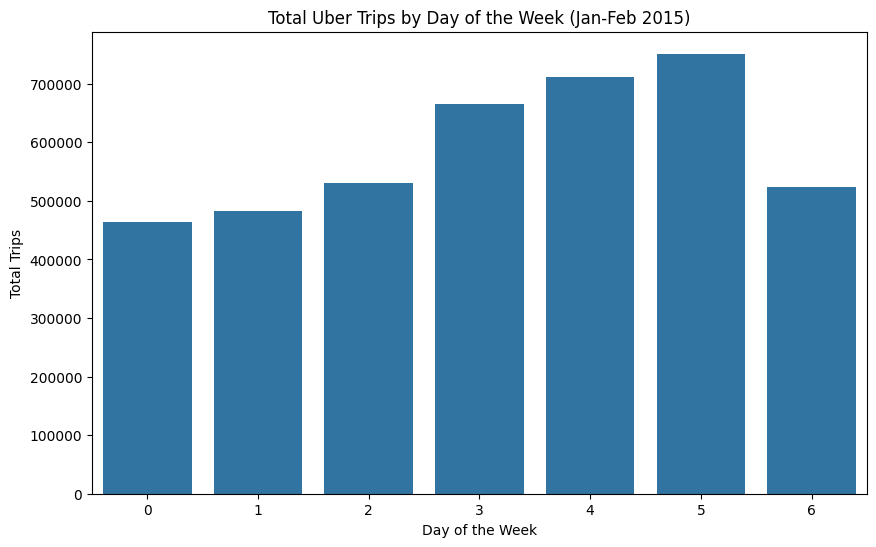

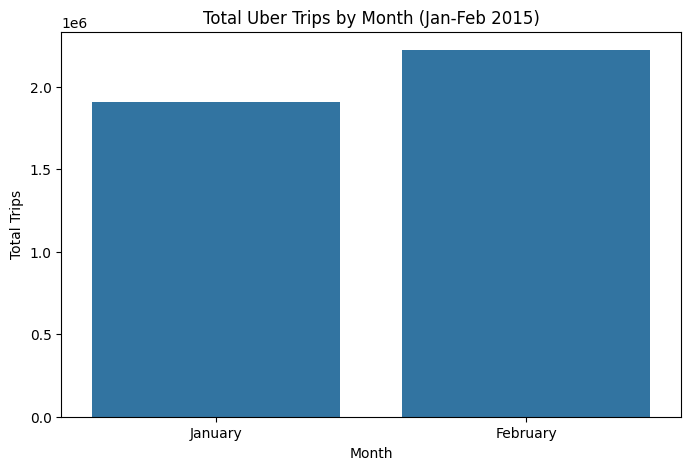

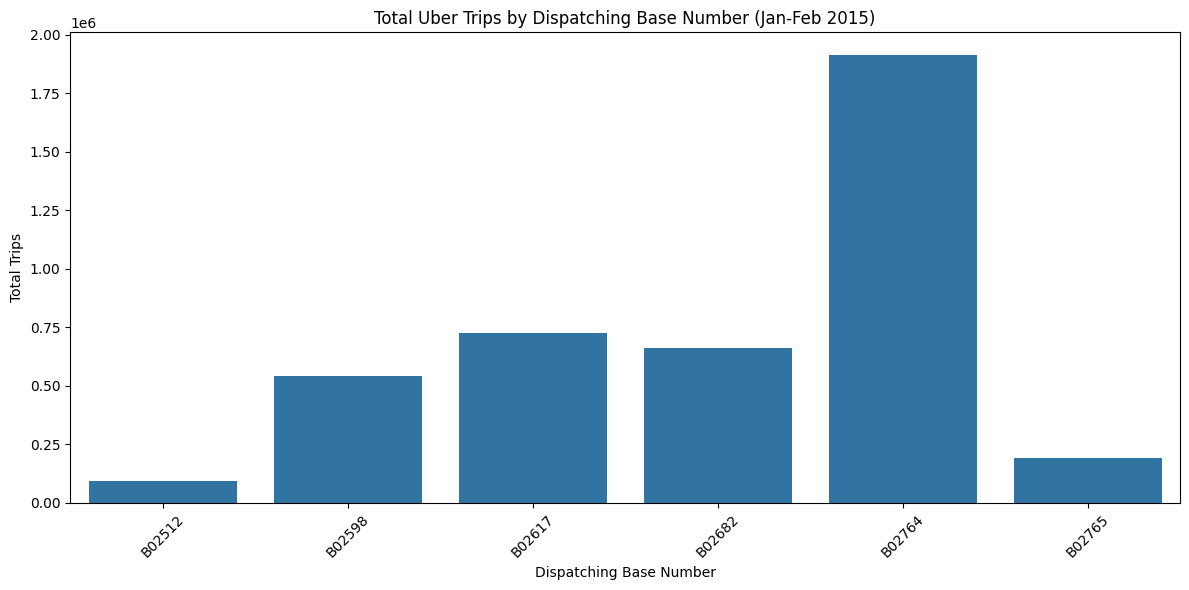

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=trips_by_day.index, y=trips_by_day.values)
plt.xlabel('Day of the Week')
plt.ylabel('Total Trips')
plt.title('Total Uber Trips by Day of the Week (Jan-Feb 2015)')
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(x=trips_by_month.index, y=trips_by_month.values)
plt.xlabel('Month')
plt.ylabel('Total Trips')
plt.title('Total Uber Trips by Month (Jan-Feb 2015)')
plt.xticks(ticks=[0, 1], labels=['January', 'February'])
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=trips_by_base.index, y=trips_by_base.values)
plt.xlabel('Dispatching Base Number')
plt.ylabel('Total Trips')
plt.title('Total Uber Trips by Dispatching Base Number (Jan-Feb 2015)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()